In [1]:
import numpy as np
import csv
import glob, os
import pandas as pd
from datetime import datetime
from gis_tools import *
import geopandas as gpd
import geemap
import ee
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, osr

In [3]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [4]:
# set directory
path = r'../grdc_africa/'
os.chdir(path)

In [5]:
# make data to analyse
lats = []
lons = []
start_ts = []
end_ts = []
ts_datapoints = []
ts_continuous = []

# load files
files = glob.glob('*_Q_Day.Cmd.txt')

# iterate through files
for file in files:
    with open(file, newline='', encoding='latin') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
            ts_counting = False
            ts_counter = 0
            cts_counter = 0
            cts_list = []

            # read through documents
            for row in spamreader:
                if len(row) > 1:

                    # add latitude, longitude and time from document
                    if row[1] == 'Latitude':
                        lats.append(float(row[-1]))
                    if row[1] == 'Longitude':
                        lons.append(float(row[-1]))
                    if row[1] == 'Time':
                        start_ts.append(row[-3])
                        end_ts.append(row[-1])

                    # check if we can finally start counting the length and continuity of the timeseries
                    if ts_counting == True:
                        if int(float(row[-1])) != -999:
                            ts_counter += 1
                            cts_counter += 1
                        else:
                            cts_list.append(cts_counter)
                            cts_counter = 0

                    # check if we finally can start counting
                    if row[0] == 'YYYY-MM-DD;hh:mm;':
                        ts_counting = True
            if len(cts_list) > 0:
                ts_continuous.append(max(cts_list))
            else:
                ts_continuous.append(cts_counter)    
            ts_datapoints.append(ts_counter)

# turn data into pandas dataframe
locdict = {'stations': files,
           'lats': lats,
           'lons': lons,
           'start': start_ts,
           'end': end_ts,
           'datapoints': ts_datapoints,
           'continuous datapoints': ts_continuous}




In [6]:
gdf_sheds = gpd.read_file(r'../HydroSHEDS/hybas_af_lev01-12_v1c/hybas_af_lev03_v1c.shp')       
gdf_stations = gpd.GeoDataFrame(data=locdict, geometry=gpd.points_from_xy(locdict['lons'], locdict['lats']), crs=gdf_sheds.crs)
gdf_stations.sort_values(by='end', ascending=False, inplace=True)
gdf_stations = gdf_stations[gdf_stations.end > '2015-01-01']

In [7]:
gdf_extent = gpd.read_file(r'../self/extent.geojson')
gdf_extent = gdf_extent.set_crs(gdf_sheds.crs, allow_override=True)

In [8]:
xy_extent = gdf_extent.boundary[0].xy
xmin_extent = np.min(xy_extent[0])
xmax_extent = np.max(xy_extent[0])
ymin_extent = np.min(xy_extent[1])
ymax_extent = np.max(xy_extent[1])

In [9]:
gdf_sheds = gdf_sheds[gdf_sheds.clip_by_rect(xmin=xmin_extent, xmax=xmax_extent, ymin=ymin_extent, ymax=ymax_extent).area >0]
gdf_sheds['centroid'] = gdf_sheds.geometry.centroid

/tmp/ipykernel_37282/19148638.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_sheds = gdf_sheds[gdf_sheds.clip_by_rect(xmin=xmin_extent, xmax=xmax_extent, ymin=ymin_extent, ymax=ymax_extent).area >0]
/tmp/ipykernel_37282/19148638.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_sheds['centroid'] = gdf_sheds.geometry.centroid


In [10]:
gdf_stations_clip = gdf_stations.clip(gdf_sheds)


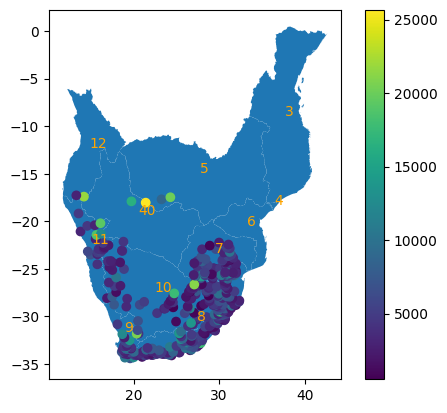

In [11]:
fig, ax = plt.subplots()
gdf_sheds.plot(ax=ax)
gdf_stations_clip.plot(column='continuous datapoints', cmap='viridis', legend=True, ax=ax)
# gdf_extent.boundary.plot(ax=ax, color='red')
for idx, row in gdf_sheds.iterrows():
    ax.annotate(text=row.name, xy=(row['centroid'].x, row['centroid'].y), color='orange')


In [12]:
# remove data scarce catchments, select catchment 9, 10, 11, 7
selection = np.array([7,8, 9 ,10, 11])
gdf_sheds = gdf_sheds[np.isin(gdf_sheds.index.to_numpy(), selection)]
gdf_stations_clip = gdf_stations_clip.clip(gdf_sheds)

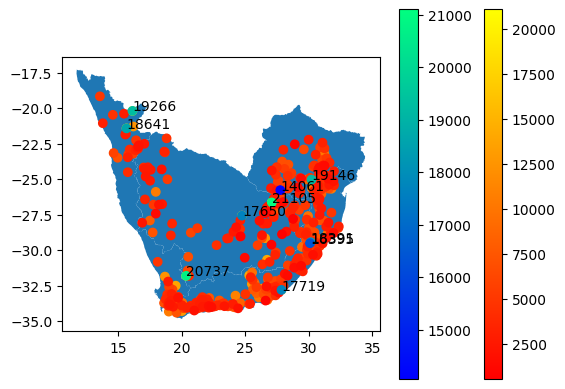

In [13]:
fig, ax = plt.subplots()
gdf_sheds.plot(ax=ax)
gdf_stations_clip = gdf_stations_clip.sort_values(by='continuous datapoints', ascending=False)
gdf_stations_clip.plot(column='continuous datapoints', cmap='autumn', legend=True, ax=ax)
gdf_stations_clip[:10].plot(column='continuous datapoints', cmap='winter', legend=True, ax=ax)

# gdf_extent.boundary.plot(ax=ax, color='red')
for idx, row in gdf_stations_clip[:10].iterrows():
    ax.annotate(text=row['continuous datapoints'], xy=(row['geometry'].x, row['geometry'].y), color='black')


In [14]:
gdf_stations_clip[:10].to_file(r'../self/top_10_selection_stations.json', driver='GeoJSON')

In [15]:
gdf_sheds.drop('centroid', axis=1).to_file(r'../self/selected_sheds.json', driver='GeoJSON')

In [16]:
# station we want to use
station = gdf_stations_clip[gdf_stations_clip.stations=='1159110_Q_Day.Cmd.txt']
station

,stations,lats,lons,start,end,datapoints,continuous datapoints,geometry
68,1159110_Q_Day.Cmd.txt,-31.806667,20.357778,1927-10,2020-09,33832,20737,POINT (20.35778 -31.80667)


In [17]:
fa_file = r'../HydroSHEDS/hyd_af_acc_30s/hyd_af_acc_30s_ext.tif'
sub_basin = sub_basins_per_station(fa_file, station)

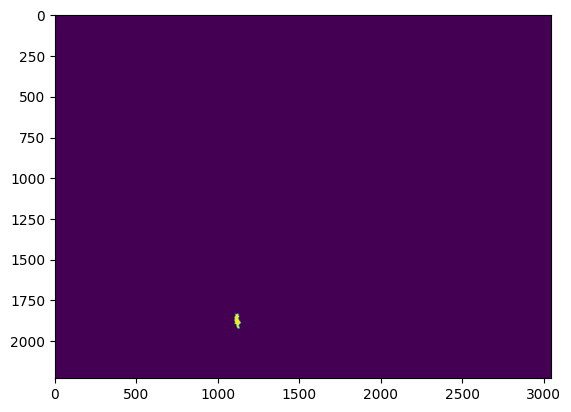

In [18]:
plt.imshow(sub_basin[0])

In [22]:
gdal_catchment = gdal.Open(fa_file)
# gdal_catchment = gdal_catchment.WriteArray(sub_basin[0])

In [45]:
rows = gdal_catchment.RasterYSize
cols = gdal_catchment.RasterXSize
driver = gdal.GetDriverByName('MEM')
mem_ds = driver.Create('', cols, rows, 1, gdal.GDT_Byte)
mem_ds.GetRasterBand(1).WriteArray(sub_basin[0])
vsimem_filename = r'/vsimem/output.tiff'
mem_ds.FlushCache()
gdal.FileFromMemBuffer(vsimem_filename, mem_ds.ReadAsArray().tobytes())

In [46]:
gdal.Open(vsimem_filename)

ERROR 4: `/vsimem/output.tiff' not recognized as a supported file format.


In [ ]:
# load earth engine data
gldas_ic = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H')

features = [
            'Albedo_inst',
            'AvgSurfT_inst',
            'ECanop_tavg',
            'ESoil_tavg',
            'Evap_tavg',
            'LWdown_f_tavg',
            'Lwnet_tavg',
            'PotEvap_tavg',
            'Psurf_f_inst',
            'Qair_f_inst',
            'Qg_tavg',
            'Qh_tavg',
            'Qle_tavg',
            'Rainf_f_tavg',
            'RootMoist_inst',
            'SWdown_f_tavg',
            'SoilMoi0_10cm_inst',
            'SoilTMP0_10cm_inst',
            'Swnet_tavg',
            'Tair_f_inst',
]
len(features)